In [191]:
from osgeo import gdal
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance as dst

In [195]:
def warp(ds, lon_min, lat_min, lon_max, lat_max, miles_per_lon, miles_per_lat, scale, out_file, 
         file_type=None, impute='bilinear'):
    
    lon_res = scale / miles_per_lon
    lat_res = scale / miles_per_lat
    
    lon_ticks = (lon_max - lon_min) / lon_res
    lat_ticks = (lat_max - lat_min) / lat_res
    
    lon_buffer = (1 - np.mod(lon_ticks, 1))
    if lon_buffer == 1:
        lon_buffer = 0
    lon_buffer = lon_buffer * lon_res
    lat_buffer = (1 - np.mod(lat_ticks, 1))
    if lat_buffer == 1:
        lat_buffer = 0
    lat_buffer = lat_buffer * lat_res
    
    bbox = [lon_min - lon_buffer/2, lat_min - lat_buffer/2, lon_max + lon_buffer/2, lat_max + lat_buffer/2]
     
    # TODO CHECK THAT WE GOT THE RIGHT BOX
    
    # return
    if file_type is None:
        file_type = out_file.split('.')[-1].upper()
    
    return gdal.Warp(out_file, ds, format=file_type, dstSRS='WGS84', xRes=lon_res, yRes=lat_res, 
                     resampleAlg=impute, outputBounds=bbox)
    

In [209]:
df = pd.read_csv('data/input/static_data_params.csv')
df

,layer,path,impute
0,evc,data\raw\LF2016_EVC_200_CONUS\LF2016_EVC_200_C...,near
1,slope,data\raw\LF2016_Slp_200_CONUS\LF2016_Slp_200_C...,bilinear
2,aspect,data\raw\LF2016_Asp_200_CONUS\LF2016_Asp_200_C...,near


In [185]:
static_paths = {}
static_paths['veg'] = r'data\raw\LF2016_EVC_200_CONUS\LF2016_EVC_200_CONUS\Tif\LC16_EVC_200.tif'
static_paths['slope'] = r'data\raw\LF2016_Slp_200_CONUS\LF2016_Slp_200_CONUS\Tif\LC16_Slp_200.tif'
static_paths['aspect'] = r'data\raw\LF2016_Asp_200_CONUS\LF2016_Asp_200_CONUS\Tif\LC16_Asp_200.tif'

In [192]:
def local_miles_per_lon_lat(bbox, k=100):
    
    # get lat, lon of center of bbox
    lat = (bbox[3] + bbox[1]) / 2
    lon = (bbox[2] + bbox[0]) / 2

    coords1 = (lat - 1 / k, lon)
    coords2 = (lat + 1 / k, lon)
    miles_per_lat = dst.distance(coords1, coords2).miles * k / 2
    coords1 = (lat, lon - 1 / k)
    coords2 = (lat, lon + 1 / k)
    miles_per_lon = dst.distance(coords1, coords2).miles * k / 2

    return miles_per_lon, miles_per_lat

In [213]:
def generate_static_data(params_df, bbox, scale, out_path):
    
    miles_per_lon, miles_per_lat = local_miles_per_lon_lat(bbox)
    
    vrts = []
    
    for _, row in params_df.iterrows():
        
        path = row['path']
        ds = gdal.Open(path)
        
        layer = row['layer']
        vrt_file = f'{out_path}/{layer}.vrt'
        vrts.append(vrt_file)
        
        warp(ds, *bbox, miles_per_lon, miles_per_lat, scale, vrt_file, impute=row['impute'])
        
    return gdal.BuildVRT(f'{out_path}/static_data.vrt', vrts, separate=True, allowProjectionDifference=False)
    

In [359]:
ds = generate_static_data(df, bbox, 0.6, '.')

In [216]:
a = gdal.Open('static_data.vrt')

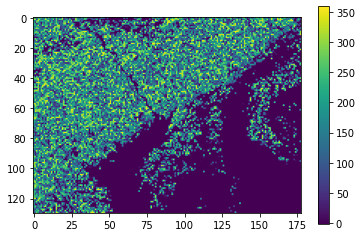

In [223]:
b = a.GetRasterBand(3).ReadAsArray()

plt.imshow(b)
plt.colorbar()

In [251]:
a = r'C:\Users\mit\data\hrrr\20210101\hrrr.t12z.wrfsfcf06.grib2'
b = gdal.Open(a)
test = gdal.Translate('test10.vrt', a, bandList=[71, 72, 73], format='VRT')



In [254]:
fields = pd.read_csv('data/input/hrrr_fields.csv')

In [261]:
from herbie.archive import Herbie

C:\Users\mit\anaconda3\envs\herbie\lib\site-packages\toolbox\cartopy_tools.py:60: UserWarning: Migrate to `cartopy_tools2` for latest updates and features.
  warnings.warn("Migrate to `cartopy_tools2` for latest updates and features.")


In [262]:
herbie_regex = '|'.join(list(fields['download_code']))

In [350]:
sys.stdout = original_out

In [351]:
print(1)

1


In [296]:
import datetime as dt

In [382]:
def extract_hrrr(time, codes, save_dir):
    
    # get HRRR forecast initialization at this time (should be real-time weather)
    H = Herbie(time, model='hrrr', product='sfc', fxx=0, save_dir=save_dir)
    
    herbie_regex = '|'.join(codes)
    
    print(dt.datetime.now())
    original_out = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    
    H.download(herbie_regex)
    
    output = new_stdout.getvalue()
    sys.stdout = original_out
    print(dt.datetime.now())
    
    direc = output.split('Created directory:')[1].split('[')[1].split(']')[0]
    l = output.split('GRIB_message')[1:]
    lookup = {code : [i for i, string in enumerate(l) if code in string] for code in list(fields['download_code'])}

    lens = list(set([len(lookup[key]) for key in lookup]))
    if lens != [1]:
        raise ValueError('Merge ambiguity for HRRR bands on download')
    
    band_lookup = {i:lookup[i][0]+1 for i in lookup}
    
    return direc, band_lookup

In [404]:
a = list(fields['download_code'])
extract_hrrr('2017-08-29 12:00', a, 'data/raw')

🏋🏻‍♂️ Found 2017-Aug-29 12:00 UTC F01 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
2022-01-14 16:13:03.979357
2022-01-14 16:13:08.186684


('C:\\Users\\mit\\Documents\\GitHub\\wildfires\\data\\raw\\hrrr\\20170829',
 {'TMP:2 m': 3,
  'SPFH:2 m': 4,
  'UGRD:10 m': 5,
  'VGRD:10 m': 6,
  'LTNG': 1,
  'PRATE': 7,
  'PRES:surface': 2})

In [405]:
file = r"C:\Users\mit\Documents\GitHub\wildfires\data\raw\hrrr\20170829\hrrr.t12z.wrfsfcf01.grib2.subset_42-45-54-56-59-60-63"

In [407]:
ds = gdal.Open(file)

bbox = [-110, 25, -75, 50]
hrrr = warp(ds, *bbox, *local_miles_per_lon_lat(bbox), 1, 'test.vrt')

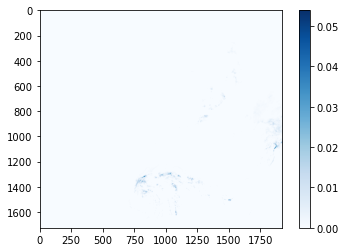

In [417]:
plt.imshow(hrrr.GetRasterBand(7).ReadAsArray(), cmap='Blues')
plt.colorbar()

In [252]:
b.RasterCount

173

In [253]:
comments = {i:b.GetRasterBand(i).GetMetadata()['GRIB_COMMENT'] for i in range(1, b.RasterCount+1)}
comments 

{1: 'Maximum / Composite radar reflectivity [dB]',
 2: 'Echo Top [m]',
 3: '(prodType 0, cat 16, subcat 201) [-]',
 4: 'Vertically-integrated liquid [kg/m]',
 5: 'Visibility [m]',
 6: 'Derived radar reflectivity [dB]',
 7: 'Derived radar reflectivity [dB]',
 8: 'Derived radar reflectivity [dB]',
 9: 'Wind speed (gust) [m/s]',
 10: 'u-component of wind [m/s]',
 11: 'v-component of wind [m/s]',
 12: 'u-component of wind [m/s]',
 13: 'v-component of wind [m/s]',
 14: 'Geopotential height [gpm]',
 15: 'Temperature [C]',
 16: 'Dew point temperature [C]',
 17: 'u-component of wind [m/s]',
 18: 'v-component of wind [m/s]',
 19: 'Geopotential height [gpm]',
 20: 'Temperature [C]',
 21: 'Dew point temperature [C]',
 22: 'Verical velocity (geometric) [m/s]',
 23: 'u-component of wind [m/s]',
 24: 'v-component of wind [m/s]',
 25: 'Geopotential height [gpm]',
 26: 'Temperature [C]',
 27: 'Dew point temperature [C]',
 28: 'u-component of wind [m/s]',
 29: 'v-component of wind [m/s]',
 30: 'Tempera

In [250]:
{i:b.GetRasterBand(i).GetMetadata() for i in range(1, b.RasterCount+1)}

{1: {'GRIB_COMMENT': 'Maximum / Composite radar reflectivity [dB]',
  'GRIB_DISCIPLINE': '0(Meteorological)',
  'GRIB_ELEMENT': 'REFC',
  'GRIB_FORECAST_SECONDS': '21600 sec',
  'GRIB_IDS': 'CENTER=7(US-NCEP) SUBCENTER=0 MASTER_TABLE=2 LOCAL_TABLE=1 SIGNF_REF_TIME=1(Start_of_Forecast) REF_TIME=2019-01-01T12:00:00Z PROD_STATUS=0(Operational) TYPE=1(Forecast)',
  'GRIB_PDS_PDTN': '0',
  'GRIB_PDS_TEMPLATE_ASSEMBLED_VALUES': '16 196 2 0 83 0 0 1 6 10 0 0 255 0 0',
  'GRIB_PDS_TEMPLATE_NUMBERS': '16 196 2 0 83 0 0 0 1 0 0 0 6 10 0 0 0 0 0 255 0 0 0 0 0',
  'GRIB_REF_TIME': '  1546344000 sec UTC',
  'GRIB_SHORT_NAME': '0-EATM',
  'GRIB_UNIT': '[dB]',
  'GRIB_VALID_TIME': '  1546365600 sec UTC'},
 2: {'GRIB_COMMENT': 'Echo Top [m]',
  'GRIB_DISCIPLINE': '0(Meteorological)',
  'GRIB_ELEMENT': 'RETOP',
  'GRIB_FORECAST_SECONDS': '21600 sec',
  'GRIB_IDS': 'CENTER=7(US-NCEP) SUBCENTER=0 MASTER_TABLE=2 LOCAL_TABLE=1 SIGNF_REF_TIME=1(Start_of_Forecast) REF_TIME=2019-01-01T12:00:00Z PROD_STATUS=0(

In [249]:
short_names = {i:b.GetRasterBand(i).GetMetadata()['GRIB_SHORT_NAME'] for i in range(1, b.RasterCount+1)}
short_names 

{1: '0-EATM',
 2: '0-CTL',
 3: '0-EATM',
 4: '0-SFC',
 5: '1000-HTGL',
 6: '4000-HTGL',
 7: '263-TMPL',
 8: '0-SFC',
 9: '25000-ISBL',
 10: '25000-ISBL',
 11: '30000-ISBL',
 12: '30000-ISBL',
 13: '50000-ISBL',
 14: '50000-ISBL',
 15: '50000-ISBL',
 16: '50000-ISBL',
 17: '50000-ISBL',
 18: '70000-ISBL',
 19: '70000-ISBL',
 20: '70000-ISBL',
 21: '70000-ISBL',
 22: '70000-ISBL',
 23: '85000-ISBL',
 24: '85000-ISBL',
 25: '85000-ISBL',
 26: '85000-ISBL',
 27: '85000-ISBL',
 28: '92500-ISBL',
 29: '92500-ISBL',
 30: '92500-ISBL',
 31: '92500-ISBL',
 32: '100000-ISBL',
 33: '100000-ISBL',
 34: '100000-ISBL',
 35: '100000-ISBL',
 36: '10000-100000-SPDL',
 37: '10000-100000-SPDL',
 38: '0.5-0.8-SIGL',
 39: '0-MSL',
 40: '100000-ISBL',
 41: '1000-HTGL',
 42: '263-TMPL',
 43: '5000-2000-HTGL',
 44: '5000-2000-HTGL',
 45: '2000-0-HTGL',
 46: '2000-0-HTGL',
 47: '3000-0-HTGL',
 48: '3000-0-HTGL',
 49: '2000-0-HTGL',
 50: '1000-0-HTGL',
 51: '0-EATM',
 52: '0.1-SIGL',
 53: '0-EATM',
 54: '0-EATM

In [181]:
boundaries = pd.read_pickle('data/clean/merged_boundaries.pkl')
fire_pixels_lookup = pd.read_csv('data/clean/fire_pixels_lookup.csv')
fire_pixels = pd.read_csv('data/clean/viirs.csv')

In [182]:
fire_pixels = pd.merge(fire_pixels, fire_pixels_lookup, on='pixel_id', how='right', validate='1:1')
fire_pixels = fire_pixels[fire_pixels['INCIDENT_IDENTIFIER'].notna()]
fire_pixels['INCIDENT_IDENTIFIER'] = fire_pixels['INCIDENT_IDENTIFIER'].astype(str)

In [183]:
fire_pixels['INCIDENT_IDENTIFIER'].value_counts()

,pixel_id,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,time,time_from_reference,INCIDENT_IDENTIFIER
0,20200817_0912_000128,44.724167,-121.681061,301.14,0.36,0.58,2020-08-17,912,N,VIIRS,n,1,287.30,0.84,N,0,2020-08-17 09:12:00,650970720.0,11837476
1,20200817_0912_000343,44.724003,-121.677238,308.83,0.36,0.58,2020-08-17,912,N,VIIRS,n,1,287.36,0.84,N,0,2020-08-17 09:12:00,650970720.0,11837476
2,20200817_0912_000446,44.775635,-121.626709,317.13,0.36,0.58,2020-08-17,912,N,VIIRS,n,1,283.47,5.94,N,0,2020-08-17 09:12:00,650970720.0,11837476
3,20200817_0912_000455,44.775272,-121.618553,317.84,0.36,0.57,2020-08-17,912,N,VIIRS,n,1,284.57,4.39,N,0,2020-08-17 09:12:00,650970720.0,11837476
4,20200817_0912_000458,44.721909,-121.677864,317.97,0.36,0.58,2020-08-17,912,N,VIIRS,n,1,287.59,1.66,N,0,2020-08-17 09:12:00,650970720.0,11837476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146369,20200911_0948_002361,37.630871,-119.533081,310.49,0.38,0.36,2020-09-11,948,N,VIIRS,n,1,279.68,1.33,N,0,2020-09-11 09:48:00,653132880.0,11961675
146370,20200818_1036_000343,43.780445,-121.961784,322.74,0.43,0.46,2020-08-18,1036,N,VIIRS,n,1,280.71,2.06,N,0,2020-08-18 10:36:00,651062160.0,11856910
146371,20200818_2018_000939,43.777805,-121.961319,367.00,0.49,0.49,2020-08-18,2018,N,VIIRS,h,1,310.75,18.93,D,0,2020-08-18 20:18:00,651097080.0,11856910
146372,20200819_2000_002066,43.779873,-121.959396,367.00,0.41,0.61,2020-08-19,2000,N,VIIRS,h,1,310.23,27.96,D,0,2020-08-19 20:00:00,651182400.0,11856910


In [180]:
stacked.GetLayerCount()

0

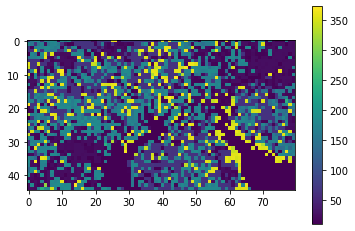

In [126]:
plt.imshow(veg.ReadAsArray())
plt.colorbar()

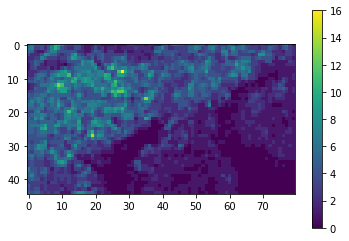

In [105]:
plt.imshow(slope.ReadAsArray())
plt.colorbar()

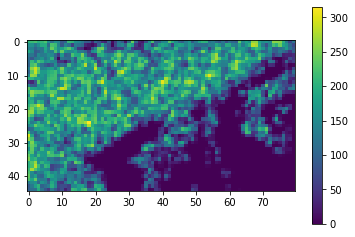

In [115]:
plt.imshow(aspect.ReadAsArray())
plt.colorbar()

In [87]:
arr = veg.ReadAsArray().astype(str)

In [88]:
zfilled = np.char.zfill(arr, 5)
zfilled

array([['00064', '00149', '00179', ..., '00168', '00024', '00025'],
       ['00176', '00154', '00064', ..., '00011', '00025', '00023'],
       ['00064', '00016', '00175', ..., '00023', '00025', '00023'],
       ...,
       ['00187', '00016', '00025', ..., '00011', '00011', '00011'],
       ['00025', '00185', '00023', ..., '00011', '00011', '00011'],
       ['00022', '00025', '00022', ..., '00011', '00011', '00011']],
      dtype='<U5')

In [93]:
veg_types = np.frompyfunc(lambda x: x[-3], 1, 1)(zfilled).astype(int)

In [94]:
import matplotlib.pyplot as plt

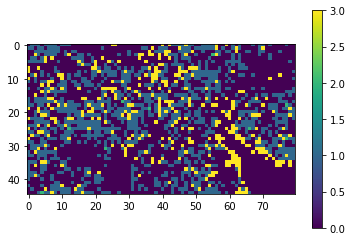

In [95]:
plt.imshow(veg_types)
plt.colorbar()

In [97]:
arr

array([['64', '149', '179', ..., '168', '24', '25'],
       ['176', '154', '64', ..., '11', '25', '23'],
       ['64', '16', '175', ..., '23', '25', '23'],
       ...,
       ['187', '16', '25', ..., '11', '11', '11'],
       ['25', '185', '23', ..., '11', '11', '11'],
       ['22', '25', '22', ..., '11', '11', '11']], dtype='<U6')

In [42]:
help(np.frompyfunc)

Help on built-in function frompyfunc in module numpy:

frompyfunc(...)
    frompyfunc(func, nin, nout, *[, identity])
    
    Takes an arbitrary Python function and returns a NumPy ufunc.
    
    Can be used, for example, to add broadcasting to a built-in Python
    function (see Examples section).
    
    Parameters
    ----------
    func : Python function object
        An arbitrary Python function.
    nin : int
        The number of input arguments.
    nout : int
        The number of objects returned by `func`.
    identity : object, optional
        The value to use for the `~numpy.ufunc.identity` attribute of the resulting
        object. If specified, this is equivalent to setting the underlying
        C ``identity`` field to ``PyUFunc_IdentityValue``.
        If omitted, the identity is set to ``PyUFunc_None``. Note that this is
        _not_ equivalent to setting the identity to ``None``, which implies the
        operation is reorderable.
    
    Returns
    -------
 

In [7]:
sliced.GetGeoTransform()

(-75.0, 0.01, 0.0, 40.0, 0.0, -0.01)

In [8]:
sliced2.GetGeoTransform()

(-75.0, 0.01, 0.0, 40.126, 0.0, -0.01)

In [9]:
np.mod(1, 1)

0

In [10]:
1.1 % 1

0.10000000000000009

In [11]:
sliced.ReadAsArray().shape

(3, 100, 200)

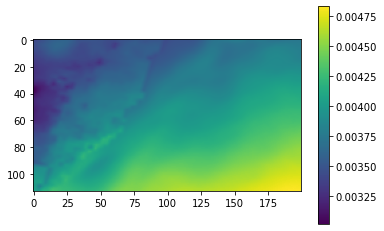

In [12]:
plt.imshow(sliced2.GetRasterBand(3).ReadAsArray())
plt.colorbar()

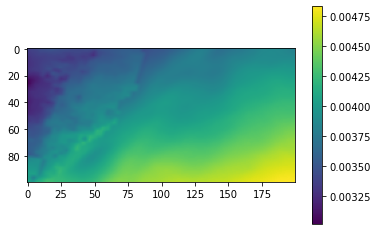

In [13]:
plt.imshow(sliced.GetRasterBand(3).ReadAsArray())
plt.colorbar()

In [15]:
sliced.GetRasterBand(1).ReadAsArray()

array([[4.00050042, 3.98997394, 3.98186386, ..., 6.74450239, 6.75708004,
        6.7696577 ],
       [3.99465269, 3.97582125, 3.96191492, ..., 6.77295227, 6.78553171,
        6.79811115],
       [4.00260689, 3.99522836, 3.98301428, ..., 6.81159714, 6.81784812,
        6.82661253],
       ...,
       [5.9814602 , 6.09401294, 6.37761558, ..., 9.08484838, 9.0802092 ,
        9.09166669],
       [5.9926772 , 6.16703093, 6.42718109, ..., 9.10720145, 9.10735919,
        9.12011163],
       [6.00409468, 6.23223693, 6.47269118, ..., 9.12955449, 9.13580229,
        9.14855652]])

In [18]:
help(np.unique)

Help on function unique in module numpy:

unique(ar, return_index=False, return_inverse=False, return_counts=False, axis=None)
    Find the unique elements of an array.
    
    Returns the sorted unique elements of an array. There are three optional
    outputs in addition to the unique elements:
    
    * the indices of the input array that give the unique values
    * the indices of the unique array that reconstruct the input array
    * the number of times each unique value comes up in the input array
    
    Parameters
    ----------
    ar : array_like
        Input array. Unless `axis` is specified, this will be flattened if it
        is not already 1-D.
    return_index : bool, optional
        If True, also return the indices of `ar` (along the specified axis,
        if provided, or in the flattened array) that result in the unique array.
    return_inverse : bool, optional
        If True, also return the indices of the unique array (for the specified
        axis, if pro

In [17]:
help(gdal.WarpOptions)

Help on function WarpOptions in module osgeo.gdal:

WarpOptions(options=None, format=None, outputBounds=None, outputBoundsSRS=None, xRes=None, yRes=None, targetAlignedPixels=False, width=0, height=0, srcSRS=None, dstSRS=None, coordinateOperation=None, srcAlpha=False, dstAlpha=False, warpOptions=None, errorThreshold=None, warpMemoryLimit=None, creationOptions=None, outputType=0, workingType=0, resampleAlg=None, srcNodata=None, dstNodata=None, multithread=False, tps=False, rpc=False, geoloc=False, polynomialOrder=None, transformerOptions=None, cutlineDSName=None, cutlineLayer=None, cutlineWhere=None, cutlineSQL=None, cutlineBlend=None, cropToCutline=False, copyMetadata=True, metadataConflictValue=None, setColorInterpretation=False, overviewLevel='AUTO', callback=None, callback_data=None)
    Create a WarpOptions() object that can be passed to gdal.Warp()
    Keyword arguments are :
      options --- can be be an array of strings, a string or let empty and filled from other keywords.
    